In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image
from keras import optimizers

C:\Users\Java\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Platform: Windows-10-10.0.16299-SP0
Tensorflow version: 1.5.0
Keras version: 2.1.3


Using TensorFlow backend.


In [2]:
import os, shutil
# 專案的根目錄路徑
os.chdir('D:\\BB105Project\\dogrecognition\\Model')

ROOT_DIR = os.getcwd()

print(os.getcwd())

breed_dir =  os.listdir('data\\select_train')[:16]


# 置放coco圖像資料與標註資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 原始數據集的路徑 ./data/train
original_dataset_dir = os.path.join(DATA_PATH, "select_train")

# 存儲小數據集的目錄 ./data/cats_and_dogs_small
base_dir = os.path.join(DATA_PATH, "dog_breed")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)
    
#----------------------------------------------------------

# 我們的訓練資料的目錄 ./data/cats_and_dogs_small/train
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 我們的驗證資料的目錄 ./data/cats_and_dogs_small/validation
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 我們的測試資料的目錄 ./data/cats_and_dogs_small/test
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
#----------------------------------------------------------  

# 狗種的圖片的訓練資料目錄 ./data/cats_and_dogs_small/train/cats
for breed in breed_dir:
    train_cats_dir = os.path.join(train_dir, breed)
    if not os.path.exists(train_cats_dir):
        os.mkdir(train_cats_dir)

    
# 狗種的圖片的驗證資料目錄 ./data/cats_and_dogs_small/validation/cats
for breed in breed_dir:
    validation_cats_dir = os.path.join(validation_dir, breed)
    if not os.path.exists(validation_cats_dir):
        os.mkdir(validation_cats_dir)

    
# 狗種的圖片的測試資料目錄 ./data/cats_and_dogs_small/test/cats
for breed in breed_dir:
    test_cats_dir = os.path.join(test_dir, breed)
    if not os.path.exists(test_cats_dir):
        os.mkdir(test_cats_dir)
    
#----------------------------------------------------------

# 複製前400個狗種的圖片到train_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    train_path = os.path.join(train_dir,breed)
    fnames = os.listdir(breed_path)[:200]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(train_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy first 200 breed images to train_breed_dir complete!')

# 複製下100個狗種的圖片到validation_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    validation_path = os.path.join(validation_dir,breed)
    fnames = os.listdir(breed_path)[200:250]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(validation_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy next 50 brees images to validation_breed_dir complete!')

# 複製下500個貓的圖片到test_cats_dir
#fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
#for fname in fnames:
#    src = os.path.join(original_dataset_dir, fname)
#    dst = os.path.join(test_cats_dir, fname)
#    if not os.path.exists(dst):
#        shutil.copyfile(src, dst)

#print('Copy next 500 cat images to test_cats_dir complete!')



#print('total training cat images:', len(os.listdir(train_cats_dir)))
#print('total training dog images:', len(os.listdir(train_dogs_dir)))
#print('total validation cat images:', len(os.listdir(validation_cats_dir)))
#print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
#print('total test cat images:', len(os.listdir(test_cats_dir)))
#print('total test dog images:', len(os.listdir(test_dogs_dir)))

D:\BB105Project\dogrecognition\Model
Copy first 200 breed images to train_breed_dir complete!
Copy next 50 brees images to validation_breed_dir complete!


# 特徵提取 (feature extraction)
特徵提取包括了使用預訓練好的網絡模型來從新樣本中提取特徵。這些特徵通過一個"新"的分類器(從頭開始訓練)。

實例化一個VGG16模型：

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # 在這裡告訴 keras我們只需要卷積基底的權重模型資訊
                  input_shape=(150, 150, 3)) # 宣告我們要處理的圖像大小與顏色通道數

我們向構造函數傳遞了三個參數：

weights, 指定從哪個權重檢查點從中初始化模型

include_top, 這是指在網絡頂部要包括或不包含密集連接的分類器。默認情況下，這個密集連接的分類器將對應於ImageNet的1000個類別。因為我們打算用自己建構的分類器（只有兩個類別，貓和狗），因此我們不需要包括它。

input_shape, 我們將餵進到網絡的圖像張量的形狀(shape)。這個參數純粹是可選的：如果我們設定，那麼網絡將能夠處理任何大小的輸入。
以下是VGG16“卷積基底”架構的細節：它與您已經熟悉的簡單卷積網絡(convnets)非常相似。

In [4]:
conv_base.summary() # 打印一下模型資訊

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 方法2: (卷積基底:凍結 + 串接新的密集分類層) >> 重新訓練

現在，我們來回顧一下我們提到的第二種特徵提取技術，這種方法要慢得多，而且會花更多的時間與計算資源，但是我們可以在訓練過程中利用數據擴充(data augmentation): 擴展conv_base模型，並進行端(end)對端(end)的訓練。

請注意，這種手法真的是非常昂貴的，所以只有在你有GPU時才應該嘗試它：在CPU上是絕對棘手的。如果您無法在GPU上運行代碼，那麼前一個手法就是你要選的路。

因為模型的行為就像堆積木，所以你可以添加一個模型（像我們的conv_base）到Sequential模型，就像添加一個圖層一樣。所以你可以執行以下操作：

### 移花+接木

In [5]:
from keras import models
from keras import layers

model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(16, activation='softmax')) # 因為我的資料集只有兩類(cat & dog)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 16,816,208
Trainable params: 16,816,208
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [8]:
# “凍結”卷積基底
conv_base.trainable = False

In [9]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import datetime as dt
start = dt.datetime.now()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=50,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

Found 3196 images belonging to 16 classes.
Found 703 images belonging to 16 classes.


In [11]:
train_generator.class_indices

{'Border Collie': 0,
 'Chihuahua': 1,
 'Doberman': 2,
 'Formosan': 3,
 'German shepherd': 4,
 'Labrador Retriever': 5,
 'Pomeranian': 6,
 'Samoyed': 7,
 'Siberian husky': 8,
 'Welsh Corgi': 9,
 'dingo': 10,
 'golden retriever': 11,
 'maltese': 12,
 'shiba': 13,
 'toy poodle': 14,
 'vizsla': 15}

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import datetime as dt
start = dt.datetime.now()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=50,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Found 3196 images belonging to 16 classes.
Found 703 images belonging to 16 classes.
Epoch 1/30
100/100 [==============================] - 215s 2s/step - loss: 2.7472 - acc: 0.1115 - val_loss: 2.5469 - val_acc: 0.2047
Epoch 2/30
100/100 [==============================] - 188s 2s/step - loss: 2.5252 - acc: 0.2171 - val_loss: 2.3464 - val_acc: 0.2789
Epoch 3/30
100/100 [==============================] - 187s 2s/step - loss: 2.3833 - acc: 0.2779 - val_loss: 2.1599 - val_acc: 0.3560
Epoch 4/30
100/100 [==============================] - 188s 2s/step - loss: 2.2388 - acc: 0.3310 - val_loss: 2.0212 - val_acc: 0.4116
Epoch 5/30
100/100 [==============================] - 188s 2s/step - loss: 2.1423 - acc: 0.3539 - val_loss: 1.9324 - val_acc: 0.4311
Epoch 6/30
100/100 [==============================] - 186s 2s/step - loss: 2.0540 - acc: 0.3746 - val_loss: 1.8516 - val_acc: 0.4520
Epoch 7/30
100/100 [==============================] - 188s 2s/step - loss: 1.9838 - acc: 0.4057 - val_loss: 1.7749 - 

In [11]:
model.save('breed16_VGG16_2.2.h5') # 把模型儲存到檔案

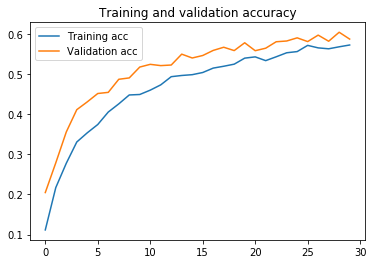

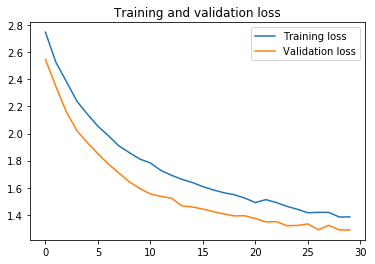

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微調 (fine-tuning)

另一種廣泛使用的模型重覆利用技術，與_特徵提取(feature extraction)_相輔相成，是 _(微調) fine-tuning_。

微調包括解凍用於特徵提取的凍結模型庫中的幾個頂層(top layers)，並且共同訓練新添加的模型部分（在我們的範例中是完全連接的分類器）和這些頂層。這被稱為“微調(fine-tuning)”，因為它稍微調整正在重複使用的模型中更抽象的表示，以使它們與當前的要處理的問題更相關。

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [ ]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層直到block4_pool都應該被凍結，而 block5_conv1，block5_conv2, block5_conv3 及 block5_pool則被解凍        
layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 把每一層是否可以被"trainable"的flat打印出來
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))

input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 使用小的learn rate
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Epoch 1/50
100/100 [==============================] - 211s 2s/step - loss: 1.2500 - acc: 0.5919 - val_loss: 1.2249 - val_acc: 0.6079
Epoch 2/50
100/100 [==============================] - 208s 2s/step - loss: 1.1463 - acc: 0.6283 - val_loss: 1.1250 - val_acc: 0.6295
Epoch 3/50
100/100 [==============================] - 207s 2s/step - loss: 1.0614 - acc: 0.6624 - val_loss: 1.1135 - val_acc: 0.6272
Epoch 4/50
100/100 [==============================] - 208s 2s/step - loss: 1.0030 - acc: 0.6757 - val_loss: 1.0971 - val_acc: 0.6554
Epoch 5/50
100/100 [==============================] - 208s 2s/step - loss: 0.9526 - acc: 0.6884 - val_loss: 1.0708 - val_acc: 0.6668
Epoch 6/50
100/100 [==============================] - 207s 2s/step - loss: 0.9093 - acc: 0.6994 - val_loss: 1.0275 - val_acc: 0.6812
Epoch 7/50
100/100 [==============================] - 207s 2s/step - loss: 0.8511 - acc: 0.7221 - val_loss: 1.0710 - val_acc: 0.6838
Epoch 8/50
100/100 [==============================] - 208s 2s/step - 

In [ ]:
model.save('breed16_VGG16_tunning_2.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()